# Problem setup

In [1]:
from sys import path
path.append('/Users/smith_sean/Documents/Python/bayesian_utilities')
from copy import deepcopy

from numpy import (array, empty, linspace, arange, tile, argsort,
                   sign, abs, sqrt, exp, log, log10, pi as π)
from numpy.linalg import eigh
from numpy.random import default_rng
my_rng = default_rng()
rand = my_rng.random

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from parameter_set import ParameterSet, get_default_params, set_default_params
from reactor_modeling import (thermo_c_ideal, spec_names, spec_molar_masses, mix_molar_mass,
                              rxn_rate_Klugherz, rxn_rate_alt, calc_spec_rates, pore_eff_thiele1,
                              cat_geom_sphere, cat_geom_cylinder, trans_Re, trans_Pr, trans_Sc,
                              turb_Nu_text, turb_Nu_finlayson, turb_Nu_Kramers,
                              film_flux_x, rxr_plugflow_x)
from common_sensitivity import morris, multi_L, sobol, active_subspaces

In [2]:
θ_cat_geom_sphere = dict(D_pellet = 2e-2)  # pellet diameter [m]
θ_cat_geom_cylinder = dict(H_pellet = 2e-2,  # pellet height [m]
                           D_pellet = 2e-2)  # pellet diameter [m]
θ_cat_geom_annularcylinder = dict(H_pellet = 2e-2,  # pellet height [m]
                                  Do_pellet = 2e-2,  # pellet outer diameter [m]
                                  Di_pellet = 1e-2)  # pellet inner diameter [m]

# Catalyst properties
θ_cat=dict(ρ_cat = 881,  # catalyst density [kg / m^3]
           a_cat = 0.8e3,  # catalyst surface area (including pores) per mass [m^2/kg]
           ε_void = 0.75,  # as-packed void fraction (gaps-between pellets) [-]
           # D_pore = 4e-6,  # diameter of the pores [m]
           D_pore = 40e-9,  # diameter of the pores [m]
           L_pore = 1e-3)  # characteristic pore length [m]
θ_cat['cat_geom'] = θ_cat_geom_sphere

In [3]:
# Submodel selections:
thermo_c = thermo_c_ideal
rxn_rate = rxn_rate_Klugherz
pore_eff = pore_eff_thiele1
cat_geom = cat_geom_sphere
turb_Nu = turb_Nu_text

# Parameter values:
PSS= type('ParameterSetSubclass', (ParameterSet,), dict())
θ = PSS(# Thermodynamic properties:
        thermo=dict(P=(2 * 101.325e3),  # pressure [Pa]
                    T=(200 + 273.15),  # Temperature [K]
                    **get_default_params(thermo_c_ideal)),
        # Chemical species properties:
        spec=dict(**get_default_params(spec_molar_masses),
                  D = array([2.0e-5, 2.6e-5, 1.7e-5, 2.1e-5, 3.3e-5, 2.4e-5]),  # diff. coefs.
                  μ_visc=2.6e-5),  # viscosity [Pa s = kg / (s m)]
        # Chemical reaction properties & parameters:
        rxn=get_default_params(rxn_rate),
        # Turbulence parameters:
        turb_bed=get_default_params(turb_Nu),
        # Catalyst properties:
        cat=θ_cat,
        # Reactor properties & operation:
        rxr=dict(l_rxr=12.8,  # reactor length [m]
                 # l_rxr=2.0,  # reactor length [m]
                 r_rxr=1.956e-2))

# Operational calculations:
Ctot = thermo_c(*θ.thermo)
n_dot = array([80.5, 91.5, 0, 0, 0, 1274]) / 30  # molar feed rates — industrial reactor [kmol/hr]
n_dot *= 1e3 / (60 * 60)  # convert to [mol/s]
x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
Q_in = n_dot.sum() / Ctot  # volumetric feed rates — industrial reactor [m^3/s]
A_tube = π * θ.r_rxr**2  # single-reactor-tube cross-sectional area [m^2]
n_tubes = 2781  # number of tubes — industrial reactor [-]
u_in = Q_in / (n_tubes * A_tube)  # superficial velocity [m/s]
print(f'inlet superficial velocity = {u_in:.2f} m/s')

# Run the coupled model:
n_z = 50
out = rxr_plugflow_x(x_in, u_in, thermo_c, rxn_rate, pore_eff, cat_geom, turb_Nu, θ, n_z)
Zrxr, Nrxr, Xrxr, Ncat, Xcat, ε_film, ε_pore = out
print(f'{Xrxr[-1] = }')

inlet superficial velocity = 0.08 m/s
Xrxr[-1] = array([0.03201344, 0.02000398, 0.01131397, 0.02531667, 0.02531667,
       0.88603527])


In [4]:
θref = deepcopy(θ)

In [5]:
def eval_design(design, verbose=True):
    n_eval, k_dims = design.shape
    f_vals = empty(n_eval)
    if verbose: print (f'Of {int(n_eval / (k_dims + 1))} saturated groupings, completed:')
    for i in range(n_eval):
        # Modify θ
        θ.R        = θref.R        + 2e-6 * (design[i, 0] - 0.5)  # absolute
        θ.P        = θref.P        * (1 +  3 / 100)**(2 * (design[i,   1] - 0.5)) # relative
        θ.T        = θref.T        + 3 * (design[i,  2] - 0.5)
        θ.M_atom   = θref.M_atom   * (1 + 0.1/ 100)**(2 * (design[i, 3:7] - 0.5))
        θ.μ_visc   = θref.μ_visc   * (1 +  5 / 100)**(2 * (design[i,   7] - 0.5))
        θ.D        = θref.D        * (1 + 90 / 100)**(2 * (design[i,8:14] - 0.5))
        θ.a_expt   = θref.a_expt   * (1 + 10 / 100)**(2 * (design[i,  14] - 0.5))
        θ.r01      = θref.r01      * (1 + 20 / 100)**(2 * (design[i,  15] - 0.5))
        θ.rKo1     = θref.rKo1     * (1 + 60 / 100)**(2 * (design[i,  16] - 0.5))
        θ.Ke1      = θref.Ke1      * (1 + 60 / 100)**(2 * (design[i,  17] - 0.5))
        θ.Ko1      = θref.Ko1      * (1 + 60 / 100)**(2 * (design[i,  18] - 0.5))
        θ.Cp1      = θref.Cp1      * (1 + 60 / 100)**(2 * (design[i,  19] - 0.5))
        θ.r02      = θref.r02      * (1 + 20 / 100)**(2 * (design[i,  20] - 0.5))
        θ.rKo2     = θref.rKo2     * (1 + 60 / 100)**(2 * (design[i,  21] - 0.5))
        θ.Ke2      = θref.Ke2      * (1 + 60 / 100)**(2 * (design[i,  22] - 0.5))
        θ.Ko2      = θref.Ko2      * (1 + 60 / 100)**(2 * (design[i,  23] - 0.5))
        θ.Cp2      = θref.Cp2      * (1 + 60 / 100)**(2 * (design[i,  24] - 0.5))
        θ.c        = θref.c        * (1 + 20 / 100)**(2 * (design[i,  25] - 0.5))
        θ.n        = θref.n        * (1 + 20 / 100)**(2 * (design[i,  26] - 0.5))
        θ.ρ_cat    = θref.ρ_cat    * (1 +  1 / 100)**(2 * (design[i,  27] - 0.5))
        θ.a_cat    = θref.a_cat    * (1 + 10 / 100)**(2 * (design[i,  28] - 0.5))
        θ.D_pellet = θref.D_pellet * (1 + 20 / 100)**(2 * (design[i,  29] - 0.5))
        θ.ε_void   = θref.ε_void   * (1 + 15 / 100)**(2 * (design[i,  30] - 0.5))
        θ.D_pore   = θref.D_pore   * (1 + 25 / 100)**(2 * (design[i,  31] - 0.5))
        θ.L_pore   = θref.L_pore   * (1 + 25 / 100)**(2 * (design[i,  32] - 0.5))
        θ.l_rxr    = θref.l_rxr    * (1 +  1 / 100)**(2 * (design[i,  33] - 0.5))
        θ.r_rxr    = θref.r_rxr    * (1 +  1 / 100)**(2 * (design[i,  34] - 0.5))
        # Modify the operating conditions:
        Ctot = thermo_c(*θ.thermo)
        n_dot = array([80.5, 91.5, 0, 0, 0, 1274]) / 30  # molar feed rates [kmol/hr]
        n_dot[0] *= (1 +  10 / 100)**(2 * (design[i,  35] - 0.5))
        n_dot[1] *= (1 +  10 / 100)**(2 * (design[i,  36] - 0.5))
        n_dot[5] *= (1 +  10 / 100)**(2 * (design[i,  37] - 0.5))
        n_dot *= 1e3 / (60 * 60)  # convert to [mol/s]
        x_in = n_dot / n_dot.sum()  # reactor-inlet mole fractions [-]
        Q_in = n_dot.sum() / Ctot  # volumetric feed rates — industrial reactor [m^3/s]
        A_tube = π * θ.r_rxr**2  # single-reactor-tube cross-sectional area [m^2]
        n_tubes = 2781  # number of tubes — industrial reactor [-]
        u_in = Q_in / (n_tubes * A_tube)  # superficial velocity [m/s]
        # Run the simulation & extract the QOI
        out = rxr_plugflow_x(x_in, u_in, thermo_c, rxn_rate, pore_eff, cat_geom, turb_Nu, θ, n_z)
        Zrxr, Nrxr, Xrxr, Ncat, Xcat, ε_film, ε_pore = out
        f_vals[i] = Xrxr[-1, 2]  # mole fraction of ethylene oxide at the reactor outlet [-]
        if verbose and (i + 1) % (k_dims + 1) == 0:
            end = '\n' if int((i + 1) / (k_dims + 1)) % 10 == 0 else ''
            print(f'   {int((i + 1) / (k_dims + 1)):-4d}...', end=end)
    if verbose: print('...done!')
    return f_vals
var_names = ['thermo.R', 'thermo.P', 'thermo.T',
             'species.M_atom_C', 'species.M_atom_H', 'species.M_atom_O', 'species.M_atom_N',
             'transport.μ_visc',
             'transport.D_eth', 'transport.D_o2', 'transport.D_ethox',
             'transport.D_co2', 'transport.D_h2o', 'transport.D_n2', 
             'rxn.a_expt', 'rxn.r01', 'rxn.rKo1', 'rxn.Ke1', 'rxn.Ko1', 'rxn.Cp1',
                           'rxn.r02', 'rxn.rKo2', 'rxn.Ke2', 'rxn.Ko2', 'rxn.Cp2',
             'turb.c', 'turb.n',
             'cat.ρ', 'cat.a', 'cat.D_pellet', 'cat.ε_void', 'cat.D_pore', 'cat.L_pore',
             'reactor.l_rxr', 'reactor.r_rxr',
             'ops.n_dot_eth', 'ops.n_dot_O2', 'ops.n_dot_N2']

# Morris One at a Time

In [6]:
k_dims = 38
n_Ls = 50
m_disc = 12
n_feval = n_Ls * (k_dims + 1)

In [7]:
%%time
μ_di, μ_adi, σ_di = morris(eval_design, k_dims, m_disc, n_Ls)

Of 50 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25...     26...     27...     28...     29...     30...
     31...     32...     33...     34...     35...     36...     37...     38...     39...     40...
     41...     42...     43...     44...     45...     46...     47...     48...     49...     50...
...done!
CPU times: user 4min 15s, sys: 807 ms, total: 4min 15s
Wall time: 4min 15s


In [8]:
%%time
_, μ_adi_2, _ = morris(eval_design, k_dims, m_disc, n_Ls)

Of 50 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25...     26...     27...     28...     29...     30...
     31...     32...     33...     34...     35...     36...     37...     38...     39...     40...
     41...     42...     43...     44...     45...     46...     47...     48...     49...     50...
...done!
CPU times: user 4min 21s, sys: 1.03 s, total: 4min 22s
Wall time: 4min 22s


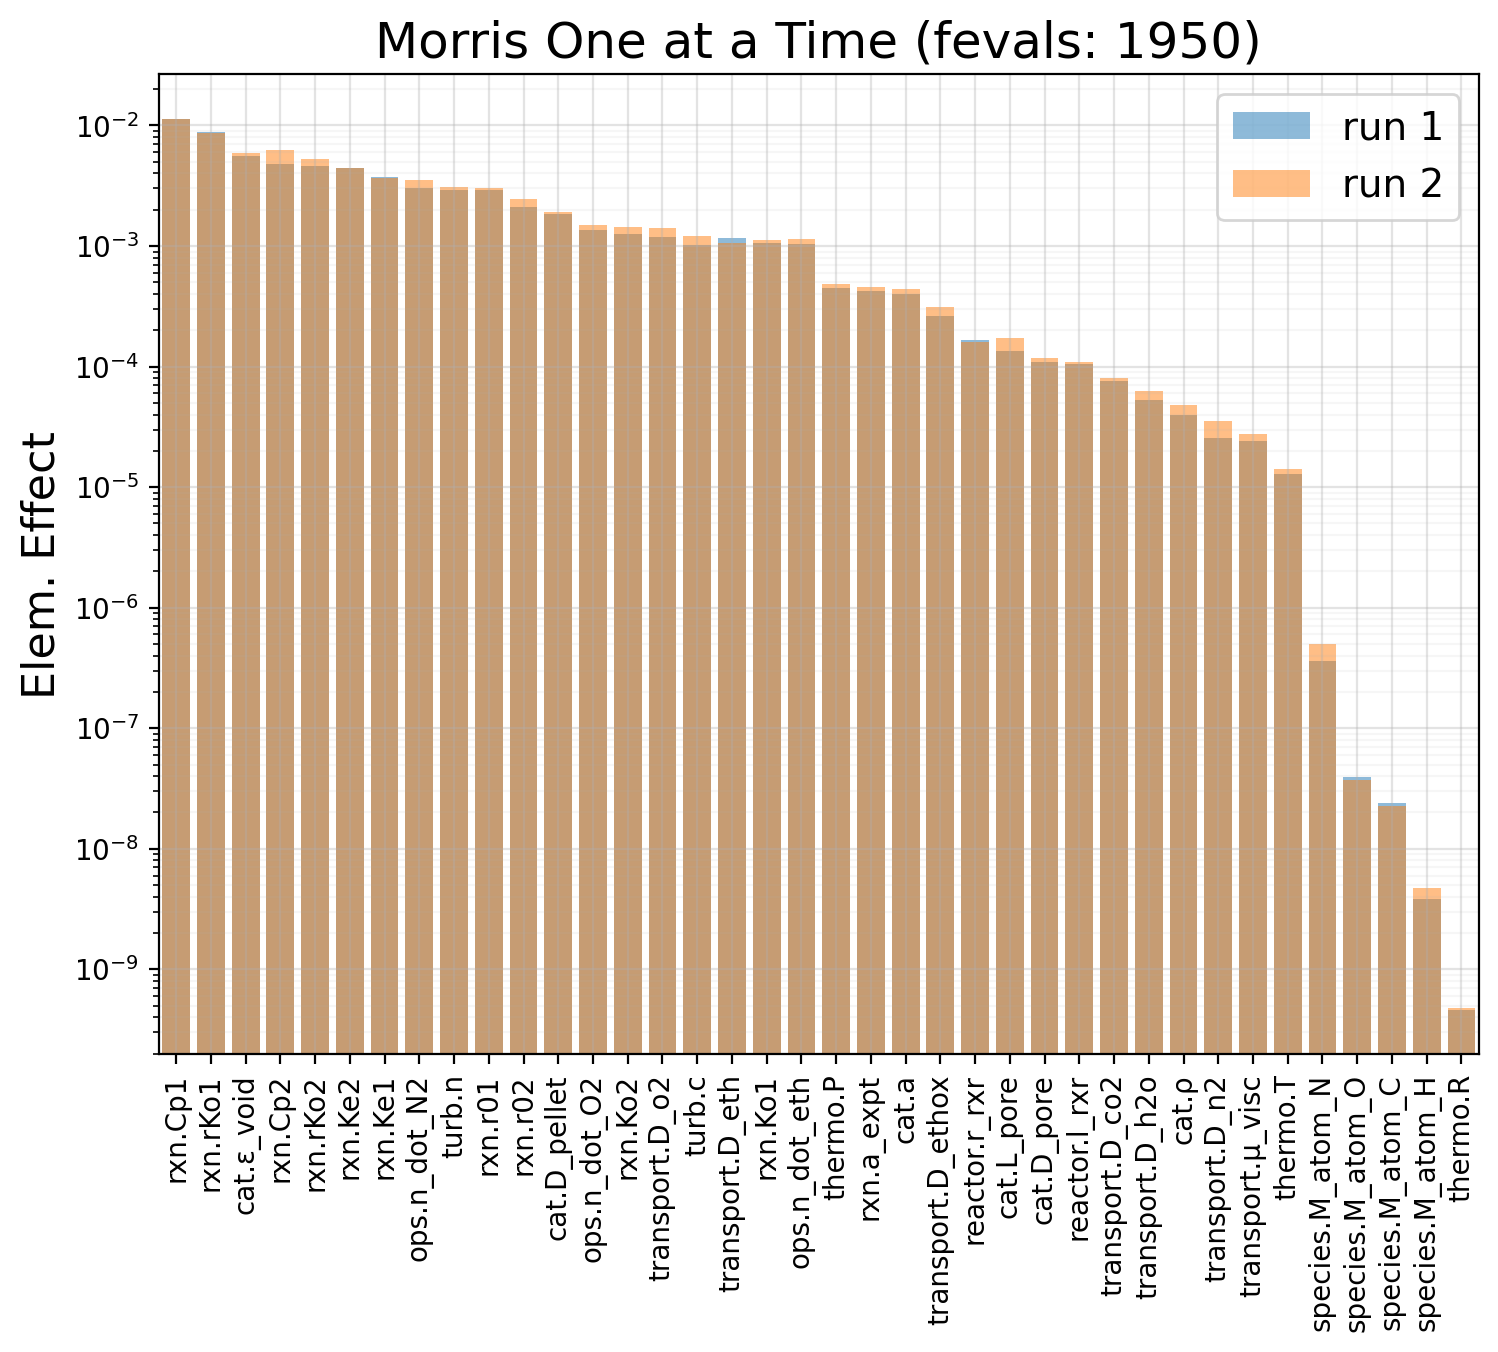

In [9]:
# Plot
i_sorted = argsort(-(μ_adi + μ_adi_2))
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), μ_adi[i_sorted], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), μ_adi_2[i_sorted], align='center', alpha=0.5, label='run 2')
plt.xlim(-0.5, k_dims - 0.5)
plt.gca().set_yscale('log')
plt.title(f'Morris One at a Time (fevals: {n_feval})', fontsize=18)
plt.ylabel('Elem. Effect', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='major', alpha=0.35)
plt.grid(True, which='minor', alpha=0.10)
plt.xticks(arange(k_dims))
plt.gca().set_xticklabels([var_names[i_sorted[i]] for i in range(k_dims)], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.93, right=0.95) ;
plt.savefig(f'sensitivity_MOAT_{m_disc}_{n_Ls}.pdf')

## w/ Campolongo's Optimization

In [10]:
k_dims = 38
n_Ls = 25
n_feval = n_Ls * (k_dims + 1)
m_disc = 12
opt = 200

In [11]:
%%time
μ_di, μ_adi, σ_di = morris(eval_design, k_dims, m_disc, n_Ls, campolongo=opt, verbose=True)

Completed campolongo optimization
Of 25 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25......done!
CPU times: user 3min 17s, sys: 712 ms, total: 3min 18s
Wall time: 3min 17s


In [12]:
%%time
_, μ_adi_2, _ = morris(eval_design, k_dims, m_disc, n_Ls, campolongo=opt, verbose=True)

Completed campolongo optimization
Of 25 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25......done!
CPU times: user 3min 16s, sys: 634 ms, total: 3min 16s
Wall time: 3min 16s


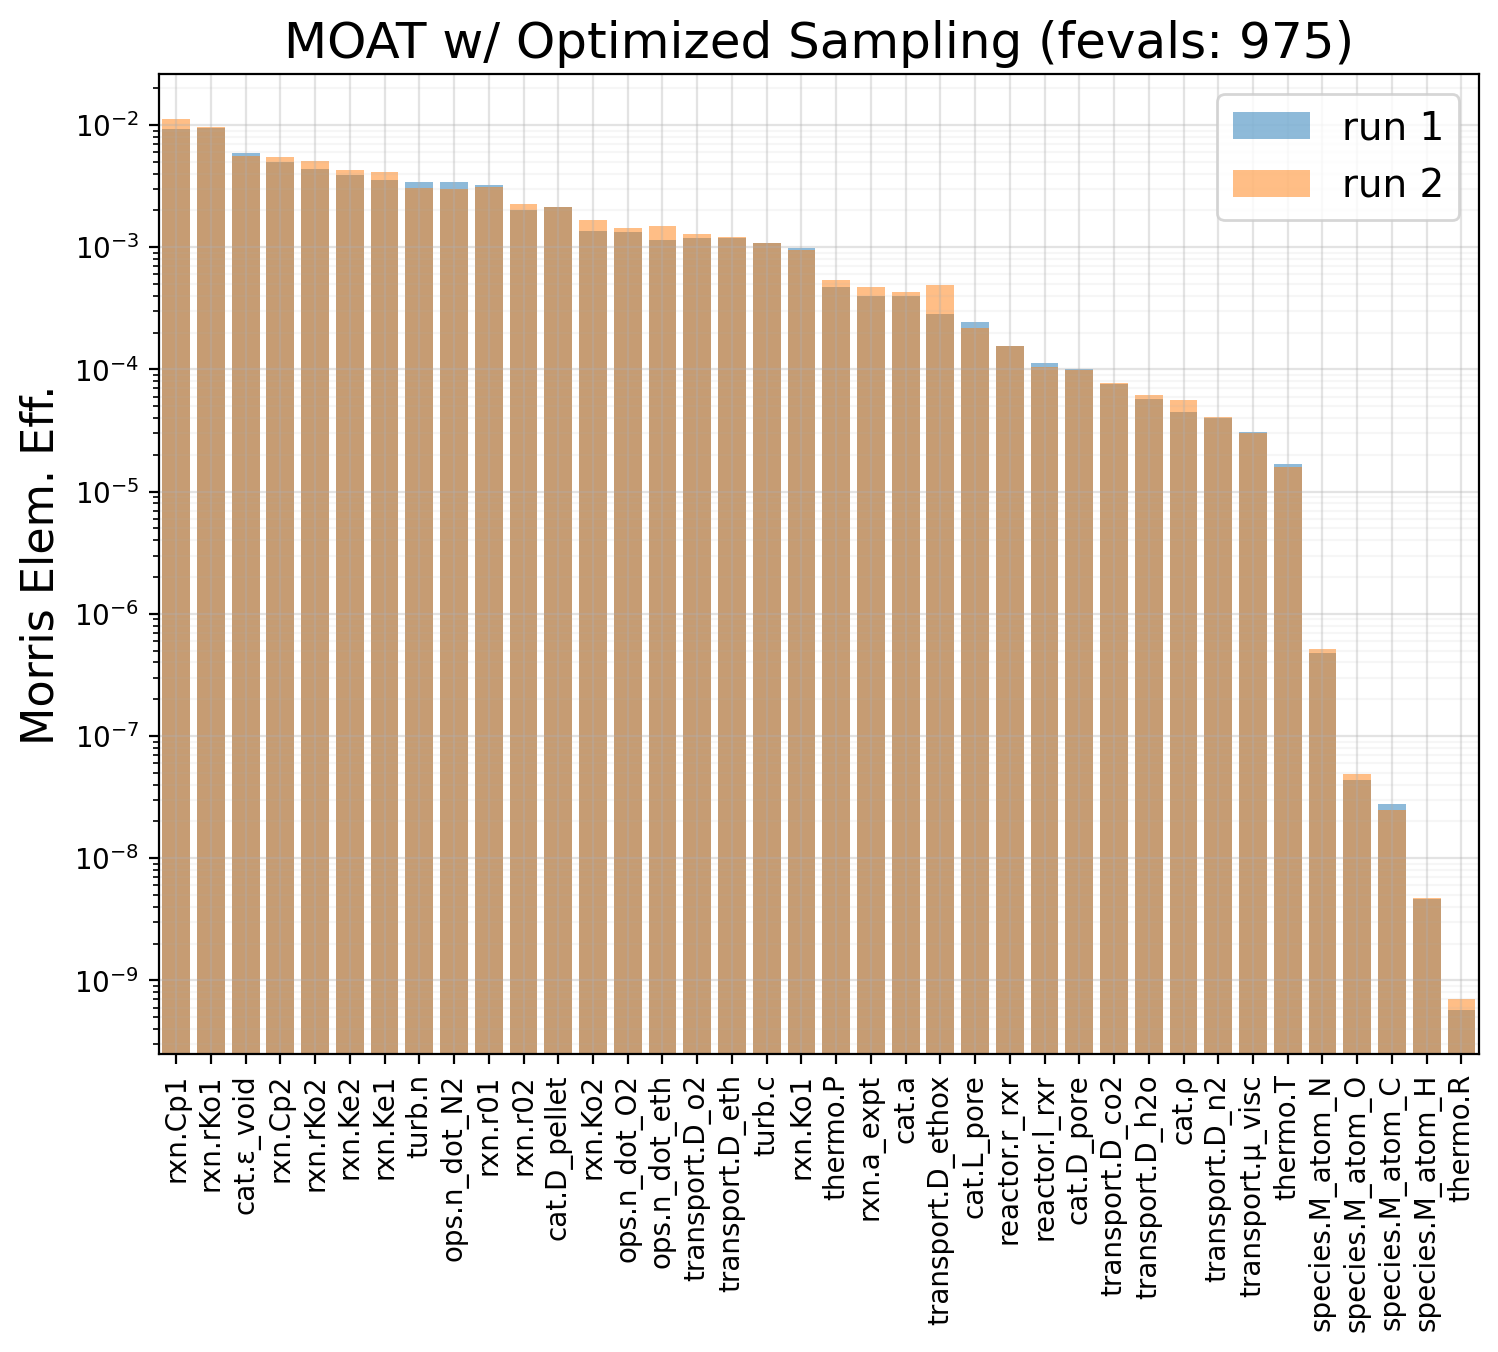

In [13]:
# Plot
i_sorted = argsort(-(μ_adi + μ_adi_2))
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), μ_adi[i_sorted], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), μ_adi_2[i_sorted], align='center', alpha=0.5, label='run 2')
plt.xlim(-0.5, k_dims - 0.5)
plt.gca().set_yscale('log')
plt.title(f'MOAT w/ Optimized Sampling (fevals: {n_feval})', fontsize=18)
plt.ylabel('Morris Elem. Eff.', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='major', alpha=0.35)
plt.grid(True, which='minor', alpha=0.10)
plt.xticks(arange(k_dims))
plt.gca().set_xticklabels([var_names[i_sorted[i]] for i in range(k_dims)], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.93, right=0.95) ;
plt.savefig(f'sensitivity_MOATopt__{m_disc}_{n_Ls}.pdf')

## Sean's modified Morris

In [14]:
k_dims = 38
n_Ls = 30
n_feval = n_Ls * (k_dims + 1)

In [15]:
%%time
μ_di, μ_adi, σ_di = multi_L(eval_design, k_dims, n_Ls)

Of 30 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25...     26...     27...     28...     29...     30...
...done!
CPU times: user 2min 40s, sys: 701 ms, total: 2min 40s
Wall time: 2min 40s


In [16]:
%%time
_, μ_adi_2, _ = multi_L(eval_design, k_dims, n_Ls)

Of 30 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25...     26...     27...     28...     29...     30...
...done!
CPU times: user 2min 38s, sys: 583 ms, total: 2min 39s
Wall time: 2min 38s


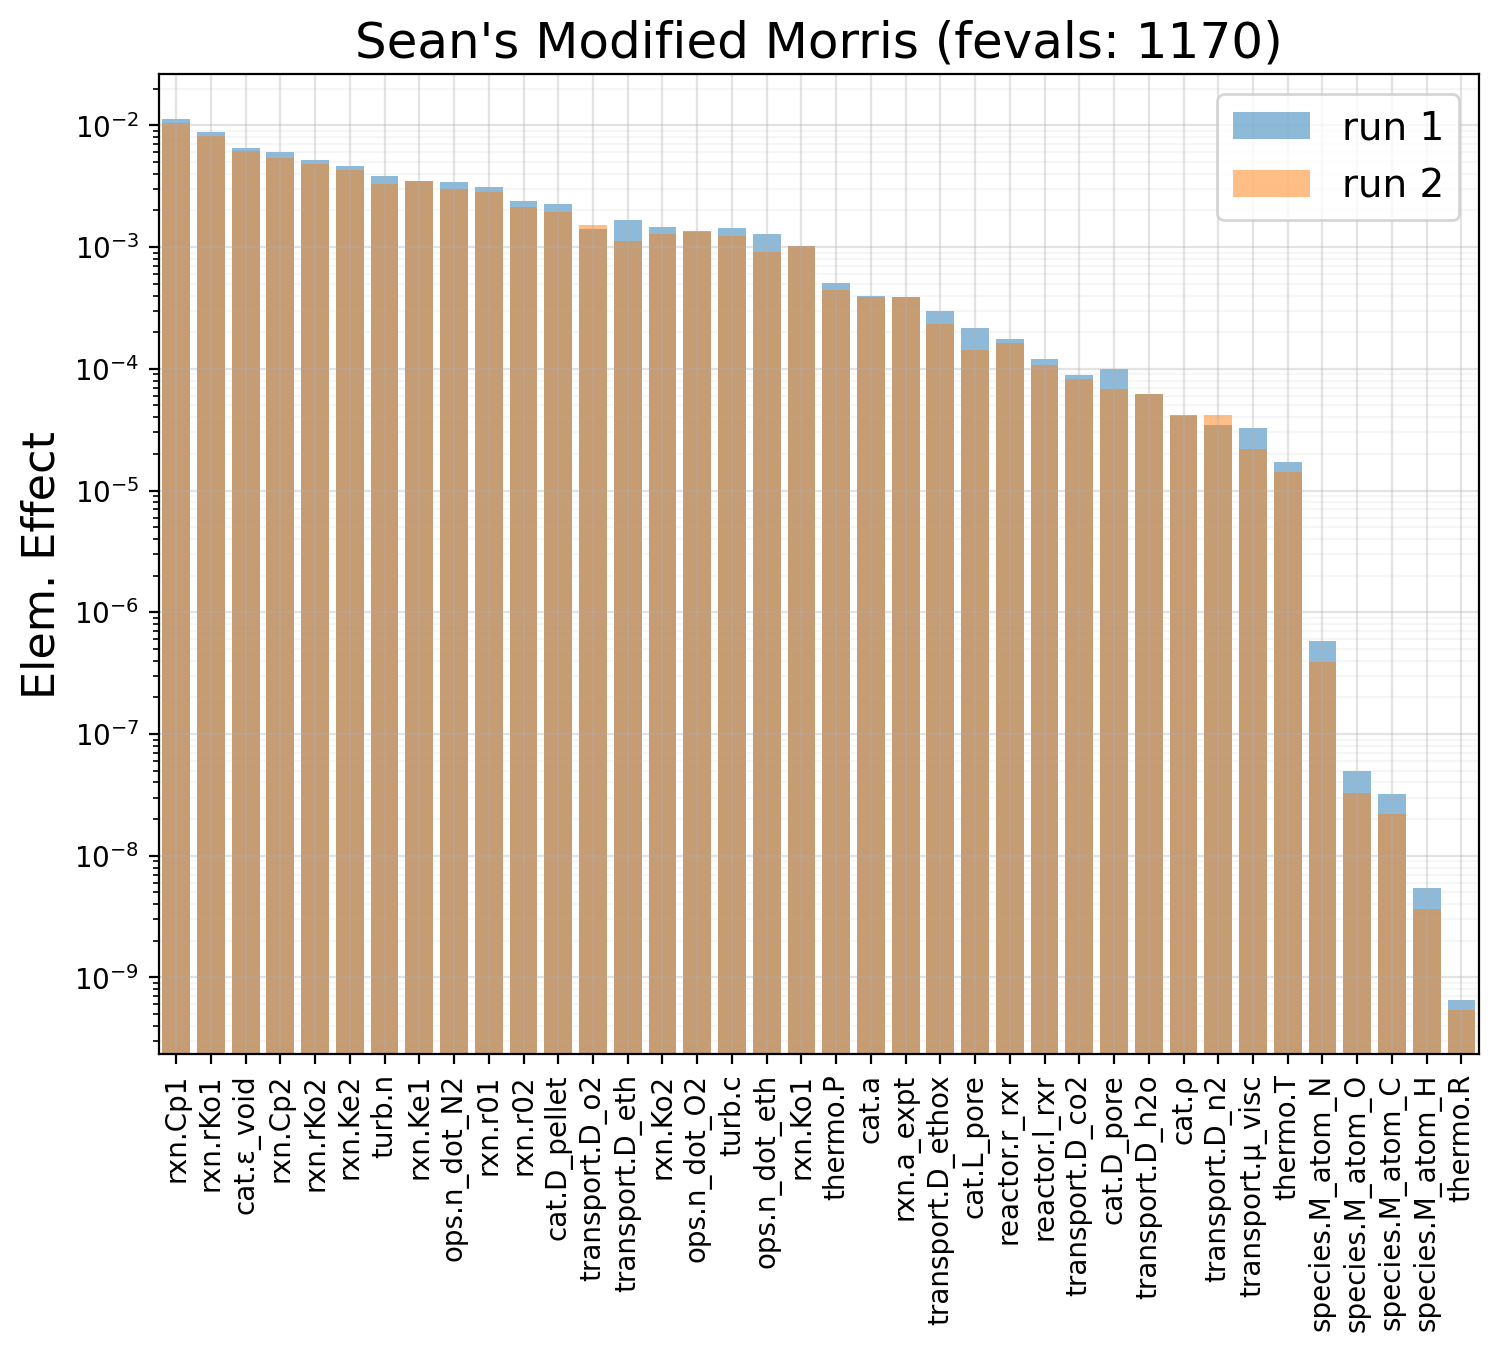

In [17]:
# Plot
i_sorted = argsort(-(μ_adi + μ_adi_2))
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), μ_adi[i_sorted], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), μ_adi_2[i_sorted], align='center', alpha=0.5, label='run 2')
plt.xlim(-0.5, k_dims - 0.5)
plt.gca().set_yscale('log')
plt.title(f"Sean's Modified Morris (fevals: {n_feval})", fontsize=18)
plt.ylabel('Elem. Effect', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='major', alpha=0.35)
plt.grid(True, which='minor', alpha=0.10)
plt.xticks(arange(k_dims))
plt.gca().set_xticklabels([var_names[i_sorted[i]] for i in range(k_dims)], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.93, right=0.95) ;
plt.savefig(f'sensitivity_Seans_{n_Ls}.pdf')

# Sobol Sensitivity

In [ ]:
k_dims = 38
log2_nL = 9
n_Ls = 2**log2_nL
n_feval = n_Ls * (k_dims + 2)
print(f'{log2_nL = }')
print(f'{n_Ls = }')
print(f'{k_dims * n_Ls = }')

In [ ]:
%%time
S1, S1tot = sobol(eval_design, k_dims, log2_nL)

In [ ]:
%%time
S1_2, _ = sobol(eval_design, k_dims, log2_nL)

In [ ]:
# Plot
i_sorted = argsort(-(S1 + S1_2))
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), S1[i_sorted], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), S1_2[i_sorted], align='center', alpha=0.5, label='run 2')
plt.xlim(-0.5, k_dims - 0.5)
plt.gca().set_yscale('log')
plt.title(f'Sobol Sens. using Saltelli 2010 (fevals: {n_feval})', fontsize=18)
plt.ylabel('sensitivity index', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='major', alpha=0.35)
plt.grid(True, which='minor', alpha=0.10)
plt.xticks(arange(k_dims))
plt.gca().set_xticklabels([var_names[i_sorted[i]] for i in range(k_dims)], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.93, right=0.95) ;
plt.savefig(f'sensitivity_Sobol_{n_Ls}.pdf')

# Active Subspaces (Rotation)

In [18]:
k_dims = 38
n_Ls = 60
n_feval = n_Ls * (k_dims + 1)

In [19]:
%%time
Λ, V = active_subspaces(eval_design, k_dims, n_Ls)

Of 60 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25...     26...     27...     28...     29...     30...
     31...     32...     33...     34...     35...     36...     37...     38...     39...     40...
     41...     42...     43...     44...     45...     46...     47...     48...     49...     50...
     51...     52...     53...     54...     55...     56...     57...     58...     59...     60...
...done!
CPU times: user 5min 17s, sys: 1.31 s, total: 5min 18s
Wall time: 5min 18s


In [20]:
%%time
Λ_2, V_2 = active_subspaces(eval_design, k_dims, n_Ls)

Of 60 saturated groupings, completed:
      1...      2...      3...      4...      5...      6...      7...      8...      9...     10...
     11...     12...     13...     14...     15...     16...     17...     18...     19...     20...
     21...     22...     23...     24...     25...     26...     27...     28...     29...     30...
     31...     32...     33...     34...     35...     36...     37...     38...     39...     40...
     41...     42...     43...     44...     45...     46...     47...     48...     49...     50...
     51...     52...     53...     54...     55...     56...     57...     58...     59...     60...
...done!
CPU times: user 5min 16s, sys: 1.86 s, total: 5min 18s
Wall time: 5min 16s


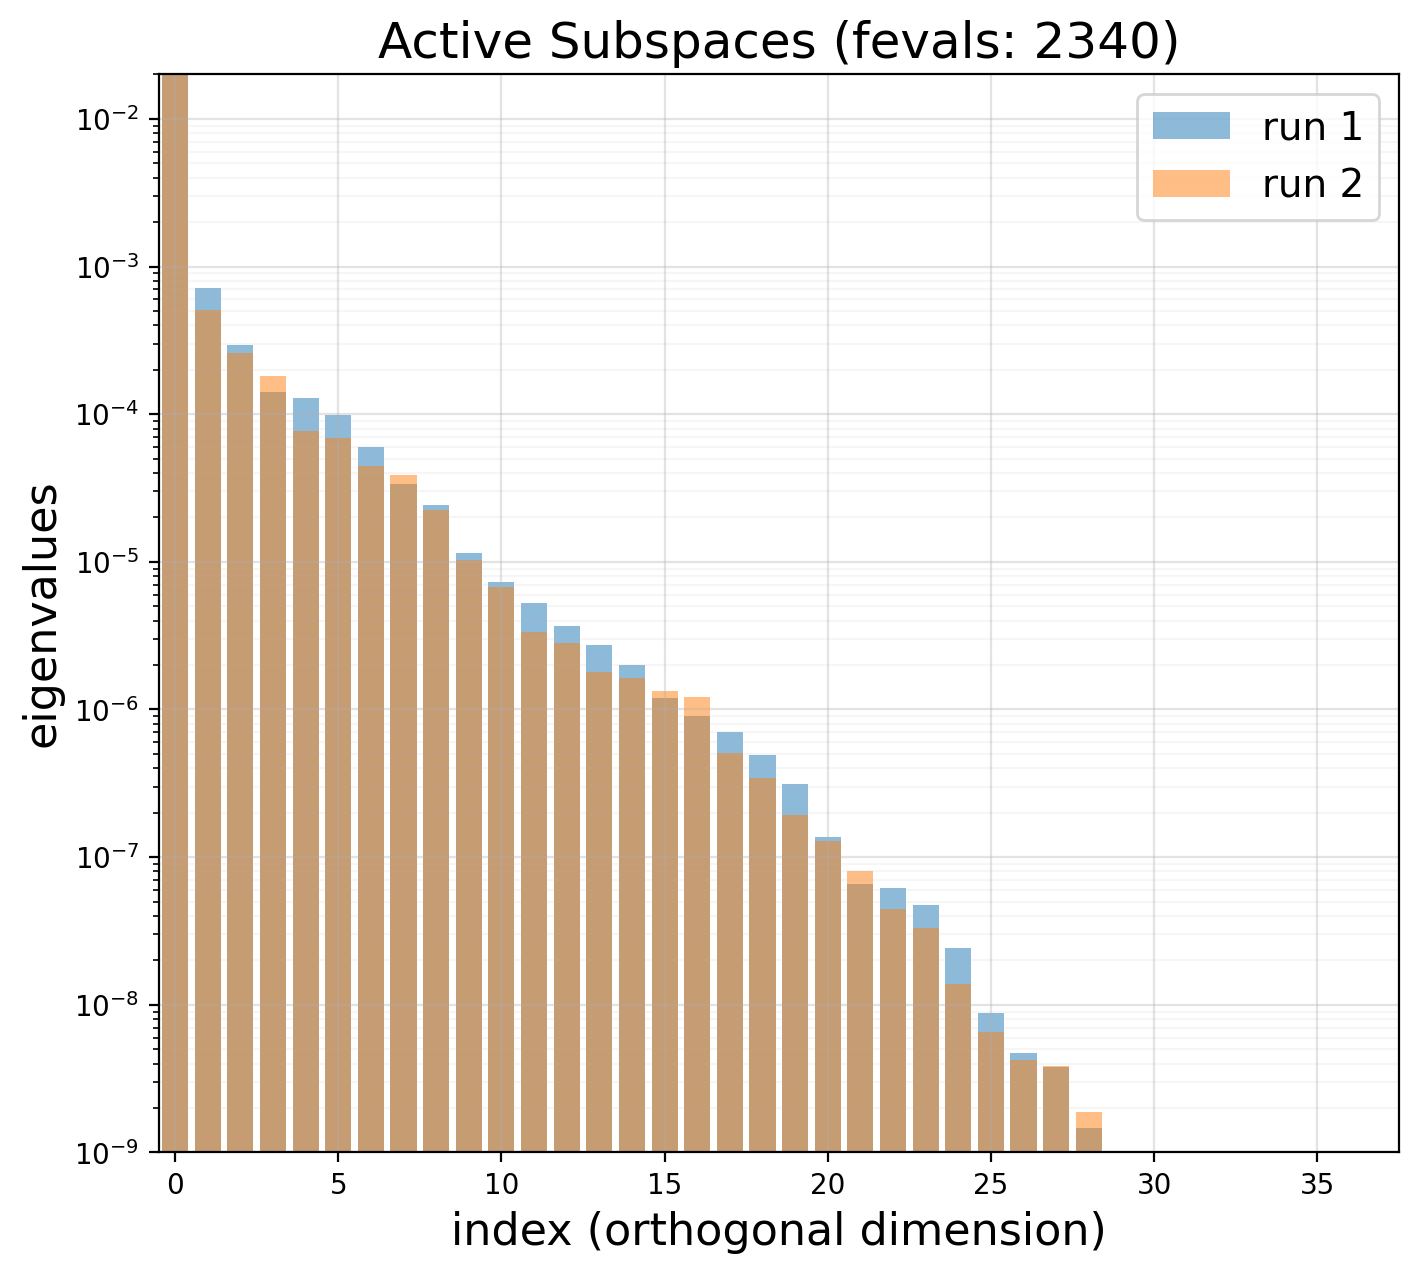

In [21]:
# Plot
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), Λ[::-1], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), Λ_2[::-1], align='center', alpha=0.5, label='run 2')
plt.gca().set_yscale('log')
plt.ylim(1e-9, 2e-2)
plt.xlim(-0.5, k_dims - 0.5)
plt.title(f'Active Subspaces (fevals: {n_feval})', fontsize=18)
plt.ylabel('eigenvalues', fontsize=16)
plt.xlabel('index (orthogonal dimension)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='major', alpha=0.35)
plt.grid(True, which='minor', alpha=0.10) ;
plt.savefig(f'sensitivity_ActSub_{n_Ls}.pdf')

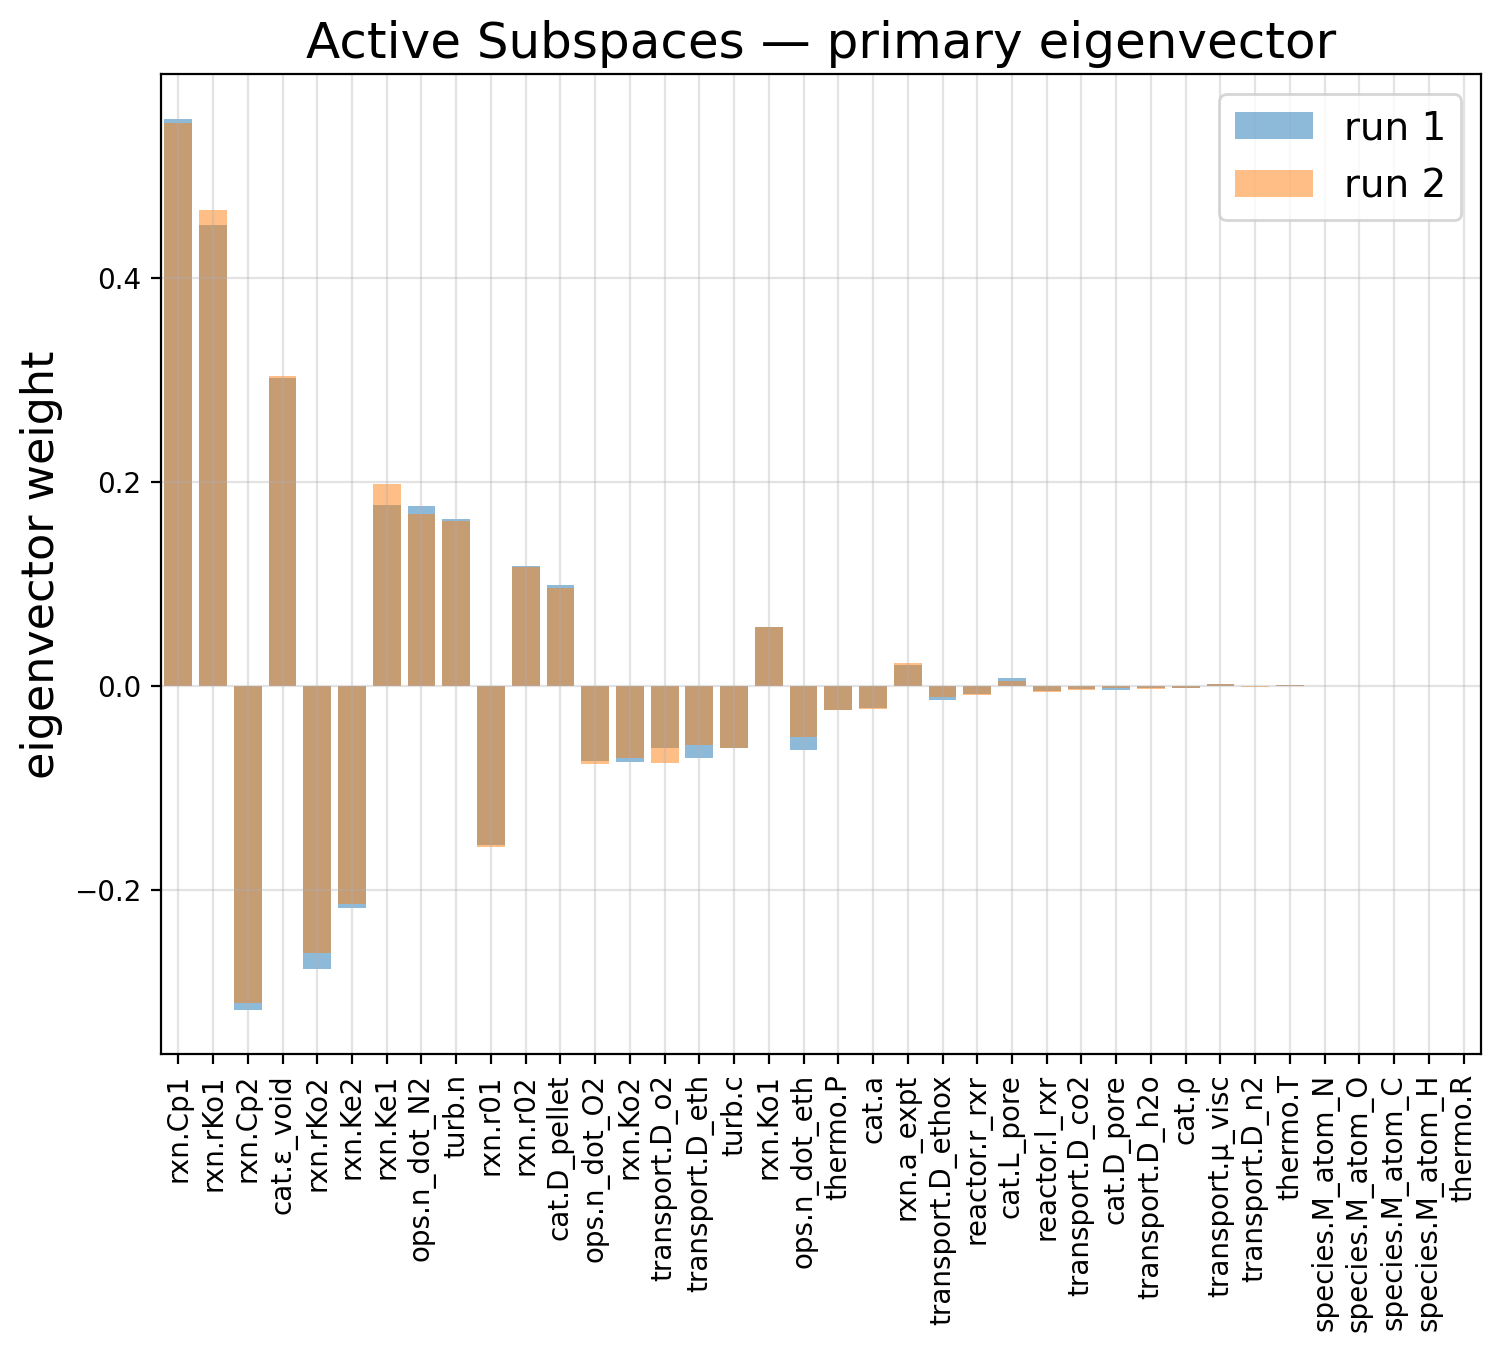

In [22]:
# Plot
i_sorted = argsort(-(abs(V[:, -1]) + abs(V_2[:, -1])))
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), sign(V[i_sorted[0], -1]) * V[i_sorted, -1], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), sign(V_2[i_sorted[0], -1]) * V_2[i_sorted, -1], align='center', alpha=0.5, label='run 2')
plt.xlim(-0.5, k_dims - 0.5)
plt.title("Active Subspaces — primary eigenvector", fontsize=18)
plt.ylabel('eigenvector weight', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.35)
plt.xticks(arange(k_dims))
plt.gca().set_xticklabels([var_names[i_sorted[i]] for i in range(k_dims)], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.93, right=0.95) ;
plt.savefig('sensitivity_ActSub_PrimeVec.pdf')

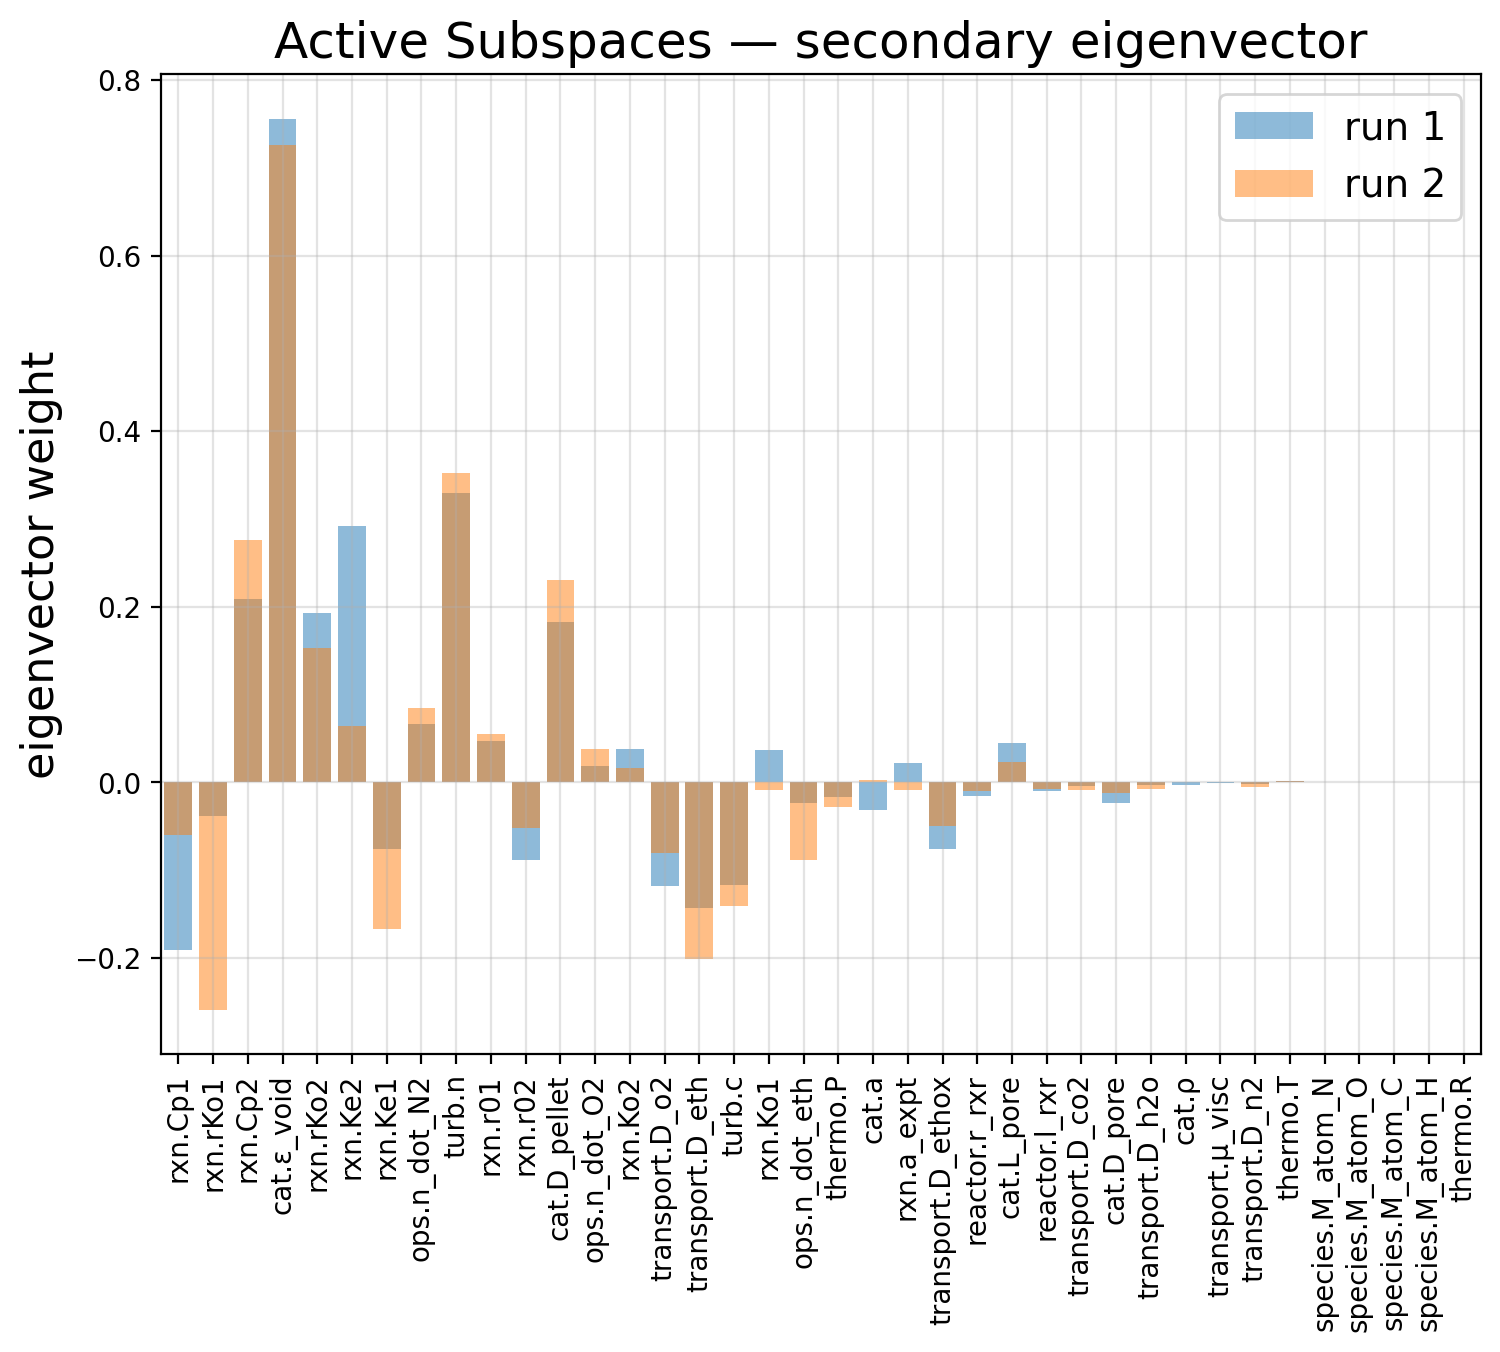

In [23]:
# Plot
fig = plt.figure(figsize=(8, 7))
plt.bar(arange(k_dims), sign(V[abs(V[:, -2]).argmax(), -2]) * V[i_sorted, -2], align='center', alpha=0.5, label='run 1')
plt.bar(arange(k_dims), sign(V_2[abs(V_2[:, -2]).argmax(), -2]) * V_2[i_sorted, -2], align='center', alpha=0.5, label='run 2')
plt.xlim(-0.5, k_dims - 0.5)
plt.title("Active Subspaces — secondary eigenvector", fontsize=18)
plt.ylabel('eigenvector weight', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.35)
plt.xticks(arange(k_dims))
plt.gca().set_xticklabels([var_names[i_sorted[i]] for i in range(k_dims)], rotation='vertical')
plt.subplots_adjust(bottom=0.23, top=0.93, right=0.95) ;
plt.savefig('sensitivity_ActSub_SecVec.pdf')

In [ ]:
# # Reconstruction
# n_active = 5  # number of active subspaces (number of eigenvectors to use)
# Y_alt = ((V[:, -n_active:] * sqrt(Λ[-n_active:])) @ X[:, -n_active:].T).T